In [ ]:
import os
from google.colab import drive
drive.mount('/content/drive')
os.chdir('./drive/MyDrive/CMU/spring_2021/IDL/hw/hw5/nbs')
print(os.getcwd())

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/CMU/spring_2021/IDL/hw/hw5/nbs


In [ ]:
#default_exp autoencoder

# Autoencoder for Image Super-Resolution

## imports

In [ ]:
import os
os.chdir('..')
print(os.getcwd())

/content/drive/MyDrive/CMU/spring_2021/IDL/hw/hw5


In [ ]:
!pip install torchinfo

In [ ]:
#export
# imports

import os
import glob
import time
from tqdm import tqdm
import matplotlib.pyplot as plt

import torch
import numpy as np
import torch.nn as nn
from PIL import Image
from torchinfo import summary
from torchvision import transforms
from torch.optim import AdamW, lr_scheduler
import torchvision.transforms.functional as TF
from torch.utils.data import Dataset, DataLoader

## Dataset class

In [ ]:
#export
class PicturesDataset(Dataset):

    def __init__(self,
                 mode,
                 final_size,
                 normalize=False,
                 data_augmentation=None,
                 interpolation=TF.InterpolationMode.NEAREST,
                 verbose=False):

        s = time.time()

        # Assertions to avoid wrong inputs
        assert mode in ['train', 'val', 'test']
        assert (mode != 'train' and data_augmentation == None) or mode == 'train'
        if data_augmentation != None:
            for item in data_augmentation:
                assert item in ['crop', 'rotate', 'flip']

        # Directory setup
        data_dirs = {'train': './data/train',
                     'val': './data/val',
                     'test': './data/test'}

        self.data_dir = data_dirs[mode]
        self.mode = mode
        self.final_size = final_size
        self.data_augmentation = data_augmentation
        self.normalize = normalize
        self.verbose = verbose
        self.interpolation = interpolation

        self.final_size_transf = transforms.Resize(size=[self.final_size, self.final_size],
                                                   interpolation=self.interpolation)

        if mode != 'test':
            self.file_names_lr = sorted(glob.glob(f'{self.data_dir}/lr/*.png'))
            self.file_names_hr = sorted(glob.glob(f'{self.data_dir}/hr/*.png'))

        else:
            self.file_names_lr = []
            for dir in os.listdir(self.data_dir):
                self.file_names_lr += glob.glob(f'{self.data_dir}/{dir}/*.png')
            self.file_names_lr = sorted(self.file_names_lr)

        if verbose: print(f'class PicturesDataset Init time: {time.time() - s:0.2f}')
   

    def __len__(self): 
        return len(self.file_names_lr)

    def __getitem__(self, idx):
            
        # Low resolution image (x)
        s = time.time()
        pic_lr = transforms.ToTensor()(Image.open(self.file_names_lr[idx]))
        if self.verbose: print(f'LR image reading time: {time.time() - s:0.2f}')

        # Flip dimensions to have height as longest dimension
        s = time.time()
        if pic_lr.shape[2] > pic_lr.shape[1]:
            pic_lr = pic_lr.transpose(1, 2)
        if self.verbose: print(f'LR Flipping time: {time.time() - s:0.2f}')

        # Normalization
        s = time.time()
        if self.normalize:
            pic_lr_mean = torch.mean(pic_lr)
            pic_lr_std = torch.std(pic_lr)
            pic_lr = (pic_lr - pic_lr_mean) / pic_lr_std
        if self.verbose: print(f'LR Normalization time: {time.time() - s:0.2f}')

        # 4x rescaling
        s = time.time()
        pic_lr_h, pic_lr_w = pic_lr.shape[1], pic_lr.shape[2]
        pic_lr = TF.resize(pic_lr,
                           size=[4*pic_lr_h, 4*pic_lr_w],
                           interpolation=self.interpolation)
        if self.verbose: print(f'LR Rescaling time: {time.time() - s:0.2f}')        
        
        if self.mode != 'test':

            # High resolution image (target, just for training and validation)
            s = time.time()
            pic_hr = transforms.ToTensor()(Image.open(self.file_names_hr[idx]))
            if self.verbose: print(f'HR image reading time: {time.time() - s:0.2f}')

            # Flip dimensions to have height as longest dimension
            s = time.time()
            if pic_hr.shape[2] > pic_hr.shape[1]:
                pic_hr = pic_hr.transpose(1, 2)
            if self.verbose: print(f'HR Flipping time: {time.time() - s:0.2f}')

            # Normalization
            s = time.time()
            if self.normalize:
                pic_hr = (pic_hr - torch.mean(pic_hr)) / torch.std(pic_hr)
            if self.verbose: print(f'HR Normalization time: {time.time() - s:0.2f}')

            # Data augmentation for x and target
            if self.data_augmentation != None:
                pic_lr, pic_hr = self.data_augmentation_transform(pic_lr, pic_hr)
          
            # Final resize
            s = time.time()
            pic_lr = self.final_size_transf(pic_lr)
            pic_hr = self.final_size_transf(pic_hr)
            if self.verbose: print(f'Final resize time: {time.time() - s:0.2f}')

            return pic_lr, pic_hr
        
        else:
            # Final resize
            s = time.time()
            pic_lr = self.final_size_transf(pic_lr)
            if self.verbose: print(f'Final resize time: {time.time() - s:0.2f}')

            pic_lr_size = {'heights': pic_lr_h, 'widths': pic_lr_w}
            pic_lr_norm_params = {'means': pic_lr_mean, 'stds': pic_lr_std}

            return pic_lr, pic_lr_size, pic_lr_norm_params

    def data_augmentation_transform(self, pic_lr, pic_hr):       

        assert pic_lr.shape == pic_hr.shape

        pic_h, pic_w = pic_lr.shape[1], pic_lr.shape[2]

        # Random rotation
        s = time.time()
        if 'rotate' in self.data_augmentation:
            angle = transforms.RandomRotation.get_params(degrees=[-45,45])

            pic_lr = TF.rotate(pic_lr, angle=angle)
            pic_hr = TF.rotate(pic_hr, angle=angle)
        if self.verbose: print(f'DA Rotation time: {time.time() - s:0.2f}')

        # Random flip
        s = time.time()
        if 'flip' in self.data_augmentation:

            # Random horizontal flipping
            if np.random.random() > 0.5:
                pic_lr = TF.hflip(pic_lr)
                pic_hr = TF.hflip(pic_hr)

            # Random vertical flipping
            if np.random.random() > 0.5:
                pic_lr = TF.vflip(pic_lr)
                pic_hr = TF.vflip(pic_hr)
        if self.verbose: print(f'DA Random Flipping time: {time.time() - s:0.2f}')

        # Random crop
        s = time.time()
        if 'crop' in self.data_augmentation:
            crop_factor = np.random.uniform(low=0.5, high=0.75)
            crop_h = np.round(crop_factor * pic_h, decimals=0).astype(int)
            crop_w = np.round(crop_factor * pic_w, decimals=0).astype(int)

            i, j, h, w = transforms.RandomCrop.get_params(pic_lr, 
                                                          output_size=(crop_h, crop_w))
            
            pic_lr = TF.crop(img=pic_lr, top=i, left=j, height=h, width=w)
            pic_hr = TF.crop(img=pic_hr, top=i, left=j, height=h, width=w)
        if self.verbose: print(f'DA Cropping time: {time.time() - s:0.2f}')

        # Resize to original shape
        s = time.time()
        original_size = transforms.Resize(size=[pic_h, pic_w], 
                                          interpolation=self.interpolation)
        pic_lr = original_size(pic_lr)
        pic_hr = original_size(pic_hr)
        if self.verbose: print(f'DA Resizing time: {time.time() - s:0.2f}')

        return pic_lr, pic_hr

## Dataset visual check

In [ ]:
#export
def plot_pictures(dataset, idx='random'):

    if idx == 'random': idx = np.random.randint(0, dataset.__len__() + 1)

    if dataset.mode != 'test':

        start = time.time()
        pic_lr, pic_hr = dataset.__getitem__(idx)
        if dataset.verbose: print(f'Total time: {time.time() - start:0.2f}\n')

        shape_lr = pic_lr.shape
        shape_hr = pic_hr.shape
        pic_lr = np.clip(pic_lr.permute(1,2,0).numpy(), 0, 1)
        pic_hr = np.clip(pic_hr.permute(1,2,0).numpy(), 0, 1)
        file_lr = dataset.file_names_lr[idx]
        file_hr = dataset.file_names_hr[idx]

        fig, axs = plt.subplots(1,2, figsize=(15,15))
        axs[0].imshow(pic_lr)
        axs[0].set_title(f'Low Resolution Image\nSet: {dataset.mode}\nNormalized: {dataset.normalize}\n(shape: {shape_lr})\n{file_lr}')
        axs[1].imshow(pic_hr)
        axs[1].set_title(f'High Resolution Image\nSet: {dataset.mode}\nNormalized: {dataset.normalize}\n(shape: {shape_hr})\n{file_hr}')
        plt.show()

    else: 

        start = time.time()
        pic_lr, pic_lr_size, pic_lr_norm_params = dataset.__getitem__(idx)
        if dataset.verbose: print(f'Total time: {time.time() - start:0.2f}\n')

        shape_lr = pic_lr.shape
        file_lr = dataset.file_names_lr[idx]

        pic_lr_unnormalized = pic_lr * pic_lr_norm_params['stds'] + pic_lr_norm_params['means']
        shape_lr_unnormalized = pic_lr_unnormalized.shape

        resize_pic = transforms.Resize(size=[pic_lr_size['heights'], pic_lr_size['widths']],
                                       interpolation=TF.InterpolationMode.BICUBIC)
        pic_lr_resized = resize_pic(pic_lr)
        shape_lr_resized = pic_lr_resized.shape

        pic_lr_resized_unnormalized = resize_pic(pic_lr_unnormalized)
        shape_lr_resized_unnormalized = pic_lr_resized_unnormalized.shape

        pic_lr = np.clip(pic_lr.permute(1,2,0).numpy(), 0, 1)
        pic_lr_unnormalized = np.clip(pic_lr_unnormalized.permute(1,2,0).numpy(), 0, 1)
        pic_lr_resized = np.clip(pic_lr_resized.permute(1,2,0).numpy(), 0, 1)
        pic_lr_resized_unnormalized = np.clip(pic_lr_resized_unnormalized.permute(1,2,0).numpy(), 0, 1)

        fig, axs = plt.subplots(2,2, figsize=(15,23))

        axs[0,0].imshow(pic_lr)
        axs[0,0].set_title(f'Low Resolution Image\nSet: {dataset.mode}\nNormalized: {True}\n(shape: {shape_lr})\n{file_lr}')

        axs[0,1].imshow(pic_lr_unnormalized)
        axs[0,1].set_title(f'Low Resolution Image\nSet: {dataset.mode}\nNormalized: {False}\n(shape: {shape_lr_unnormalized})\n{file_lr}')

        axs[1,0].imshow(pic_lr_resized)
        axs[1,0].set_title(f'Low Resolution Image\nOriginal size\nSet: {dataset.mode}\nNormalized: {True}\n(shape: {shape_lr_resized})\n{file_lr}')

        axs[1,1].imshow(pic_lr_resized_unnormalized)
        axs[1,1].set_title(f'Low Resolution Image\nOriginal size\nSet: {dataset.mode}\nNormalized: {False}\n(shape: {shape_lr_resized_unnormalized})\n{file_lr}')


        plt.show()

class PicturesDataset Init time: 0.02
LR image reading time: 0.73
LR Flipping time: 0.00
LR Normalization time: 0.00
LR Rescaling time: 0.06
HR image reading time: 1.47
HR Flipping time: 0.00
HR Normalization time: 0.04
DA Rotation time: 0.19
DA Random Flipping time: 0.69
DA Cropping time: 0.00
DA Resizing time: 0.13
Final resize time: 0.18
Total time: 3.50



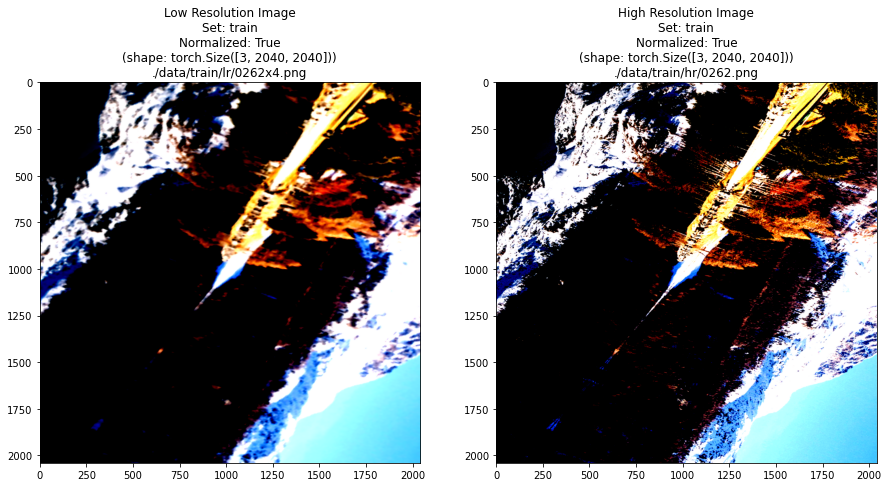

In [ ]:
mode = 'train'
FINAL_SIZE = 2040
normalize=True
data_augmentation = ['crop', 'rotate', 'flip'] if mode == 'train' else None
interpolation = TF.InterpolationMode.BILINEAR
verbose=True

dataset = PicturesDataset(mode=mode, 
                          final_size=FINAL_SIZE,
                          normalize=normalize, 
                          data_augmentation=data_augmentation, 
                          interpolation=interpolation,
                          verbose=verbose)

plot_pictures(dataset=dataset, idx='random')

## DataLoader

In [ ]:
#export
def create_dataloaders(mc):

    train_dataset = PicturesDataset(mode='train', 
                                    final_size=mc['final_size'],
                                    normalize=mc['normalize'], 
                                    data_augmentation=mc['data_augmentation'], 
                                    interpolation=mc['interpolation'],
                                    verbose=False)
    
    val_dataset =   PicturesDataset(mode='val', 
                                    final_size=mc['final_size'],
                                    normalize=mc['normalize'], 
                                    data_augmentation=None, 
                                    interpolation=mc['interpolation'],
                                    verbose=False)
    
    test_dataset =  PicturesDataset(mode='test', 
                                    final_size=mc['final_size'],
                                    normalize=mc['normalize'], 
                                    data_augmentation=None, 
                                    interpolation=mc['interpolation'],
                                    verbose=False)
    
    display_str  = f'n_train: {len(train_dataset)} '
    display_str += f'n_val: {len(val_dataset)} '
    display_str += f'n_test: {len(test_dataset)} '
    print(display_str)

    train_loader = DataLoader(train_dataset, 
                              shuffle=True, 
                              batch_size=mc['batch_size'], 
                              num_workers=NUM_WORKERS, 
                              pin_memory=torch.cuda.is_available(),
                              drop_last=True)
    
    val_loader = DataLoader(val_dataset,
                            shuffle=False, 
                            batch_size=32,
                            num_workers=NUM_WORKERS, 
                            pin_memory=torch.cuda.is_available(),
                            drop_last=True)
    
    test_loader = DataLoader(test_dataset,
                             shuffle=False, 
                             batch_size=32,
                             num_workers=NUM_WORKERS, 
                             pin_memory=torch.cuda.is_available(),
                             drop_last=False)
    
    return train_loader, val_loader, test_loader

In [ ]:
FINAL_SIZE = 2040
NUM_WORKERS = 8 if torch.cuda.is_available() else 0

mc = {'h_channels': [8, 16, 32],
      'final_size': FINAL_SIZE,
      'normalize': True,
      'data_augmentation': ['crop', 'rotate', 'flip'],
      'interpolation': TF.InterpolationMode.BILINEAR,
      'batch_size': 32}

train_loader, val_loader, test_loader = create_dataloaders(mc)

print('\nTrain loader:')
s = time.time()
batch_lr, batch_hr = next(iter(train_loader))
print(time.time() - s)
print(f'batch_lr.shape: {batch_lr.shape}')
print(f'batch_hr.shape: {batch_hr.shape}')

print('\nVal loader:')
s = time.time()
batch_lr, batch_hr = next(iter(val_loader))
print(time.time() - s)
print(f'batch_lr.shape: {batch_lr.shape}')
print(f'batch_hr.shape: {batch_hr.shape}')

print('\nTest loader:')
s = time.time()
batch_lr, batch_lr_size, batch_lr_norm_params = next(iter(test_loader))
print(time.time() - s)
print(f'batch_lr.shape: {batch_lr.shape}')
print(f'batch_hr_sizes:\n{batch_lr_size}')
print(f'batch_lr_norm_params:\n{batch_lr_norm_params}')

n_train: 800 n_val: 100 n_test: 328 

Train loader:
110.97947311401367
batch_lr.shape: torch.Size([32, 3, 2040, 2040])
batch_hr.shape: torch.Size([32, 3, 2040, 2040])

Val loader:
95.43736958503723
batch_lr.shape: torch.Size([32, 3, 2040, 2040])
batch_hr.shape: torch.Size([32, 3, 2040, 2040])

Val loader
26.40924572944641
batch_lr.shape: torch.Size([32, 3, 2040, 2040])
batch_hr_sizes:
{'heights': tensor([293, 293, 293, 293, 293, 293, 293, 293, 293, 293, 293, 293, 293, 293,
        293, 293, 293, 293, 293, 293, 293, 293, 293, 293, 293, 293, 293, 293,
        293, 293, 293, 293]), 'widths': tensor([207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207,
        207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207,
        207, 207, 207, 207])}
batch_lr_norm_params:
{'means': tensor([0.3293, 0.5937, 0.4838, 0.5888, 0.3032, 0.5810, 0.6584, 0.7407, 0.6511,
        0.3526, 0.5771, 0.6041, 0.6758, 0.5539, 0.6506, 0.7213, 0.6886, 0.8503,
        0.2527, 0.8750, 0.

## Autoencoder Model

In [ ]:
#export
class _autoencoder(nn.Module):

    def __init__(self,
                 h_channels):

        super(_autoencoder, self).__init__()

        self.channels_enc = [3]
        self.channels_enc += h_channels.copy()
        self.channels_dec = [self.channels_enc[-1]]
        self.channels_dec += h_channels[::-1].copy()

        # Input layer: (B, C=3, H, W)

        # Encoder
        encoder_layers = []

        for i in range(len(h_channels)):
            layer = [nn.Conv2d(in_channels=self.channels_enc[i], 
                               out_channels=self.channels_enc[i+1], 
                               kernel_size=3,
                               padding=1),
                     nn.BatchNorm2d(num_features=self.channels_enc[i+1]),
                     nn.ReLU(),
                     nn.MaxPool2d(kernel_size=2,
                                  stride=2)]
            encoder_layers += layer

        self.encoder_layers = nn.ModuleList(encoder_layers)

        # Decoder
        decoder_layers = []

        for i in range(len(self.channels_dec) - 1):
            layer = [nn.ConvTranspose2d(in_channels=self.channels_dec[i], 
                                        out_channels=self.channels_dec[i+1], 
                                        kernel_size=2,
                                        stride=2),
                     nn.BatchNorm2d(num_features=self.channels_dec[i+1]),
                     nn.ReLU()]
            decoder_layers += layer

        decoder_layers += [nn.Conv2d(in_channels=self.channels_dec[i+1], 
                                    out_channels=self.channels_enc[0], 
                                    kernel_size=3,
                                    padding=1),
                           nn.BatchNorm2d(num_features=self.channels_enc[0]),
                           nn.ReLU()]
        
        self.decoder_layers = nn.ModuleList(decoder_layers)
        

    def forward(self, x):

        # Encoding (Convolutional Blocks - Downsampling)
        output_shapes = []

        for layer in self.encoder_layers:            
            if isinstance(layer, torch.nn.modules.pooling.MaxPool2d):
                output_shapes.append(x.shape)
            x = layer(x)

        output_shapes = output_shapes[::-1]

        # Decoding (Transpose Convolutional Blocks - Upsampling)
        for i, layer in enumerate(self.decoder_layers[:-3]):
            if i % 3 == 0: # if layer is ConvTranspose2D, then call it preserving output size from encoder
                x = layer(x, output_size=output_shapes[i//3])     
            else:
                x = layer(x)
        
        for layer in self.decoder_layers[-3:]:
            x = layer(x)
    
        return x


In [ ]:
mode = 'train'
FINAL_SIZE = 2040
normalize=True
data_augmentation = ['crop', 'rotate', 'flip'] if mode == 'train' else None
interpolation = TF.InterpolationMode.BILINEAR
verbose=False

dataset = PicturesDataset(mode=mode, 
                          final_size=FINAL_SIZE,
                          normalize=normalize, 
                          data_augmentation=data_augmentation, 
                          interpolation=interpolation,
                          verbose=verbose)

idx = np.random.randint(0, dataset.__len__() + 1)

pic_lr, pic_hr = dataset.__getitem__(idx)
pic_lr = pic_lr.unsqueeze(0)

print(f'input  shape: {pic_lr.shape}')
model = _autoencoder(h_channels=[8, 16, 32])
out_pic = model(pic_lr)
print(f'output shape: {out_pic.shape}')
print(summary(model, input_size=(32, 3, 2040, 2040)))

input  shape: torch.Size([1, 3, 2040, 2040])
output shape: torch.Size([1, 3, 2040, 2040])


## Autoencoder Model Wrapper

In [ ]:
class autoencoder(object):

    def __init__(self, params):
        
        super().__init__()
        self.params = params
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        
        # Instantiate model

        #------------------------------------ Model & Optimizer ----------------------------------#    

        self.model = _autoencoder(h_channels=params['h_channels'])
        
        print(summary(self.model, 
                      input_size=(params['batch_size'], 3, params['final_size'], params['final_size'])))

        self.model = nn.DataParallel(self.model).to(self.device)

        self.optimizer = AdamW(self.model.parameters(), 
                               lr=params['initial_lr'],
                               weight_decay=params['weight_decay']) # Moved the optimizer outside
                                                                    # the fit method to also save 
                                                                    # the optimizer state_dict.

    def fit(self, train_loader, val_loader):
        
        params = self.params
        
        #------------------------------------- Optimization --------------------------------------#
        criterion = nn.MSELoss()

        scheduler = torch.optim.lr_scheduler.StepLR(self.optimizer, 
                                                    step_size=params['adjust_lr_step'], 
                                                    gamma=params['lr_decay'])
                                                                           
        scaler = torch.cuda.amp.GradScaler()
        
        #---------------------------------------- Logging -----------------------------------------#
        step = 0
        epoch = 0
        break_flag = False
        self.best_loss = 1_000_000
        
        trajectories = {'step':  [], 
                        'epoch':  [],
                        'train_loss': [], 
                        'val_loss': []}

        print('\n'+'='*43+' Fitting  Autoencoder Model '+'='*43)

        while step <= params['iterations']:
            # Train
            epoch += 1
                        
            self.model.train()

            start_epoch = time.time()

            for batch_idx, (x_lr, target_hr) in enumerate(train_loader):

                step+=1           
                
                if break_flag: # weird epoch breaker
                    continue
                
                #--------------------------------- Forward and Backward ---------------------------------#
                x_lr = x_lr.to(self.device) 
                target_hr = target_hr.to(self.device) 
                
                self.optimizer.zero_grad()
                
                with torch.cuda.amp.autocast():

                    outputs = self.model(x_lr.float()) 

                    loss = criterion(outputs, target_hr)

                    scaler.scale(loss).backward()
                    scaler.step(self.optimizer)
                    # Update optimizer learning rate
                    scaler.update()
                 
                del x_lr
                del target_hr
                torch.cuda.empty_cache()
                
                scheduler.step()

            time_epoch = time.time() - start_epoch

                #----------------------------------- Evaluate metrics -----------------------------------#
                if (step % params['display_step']) == 0:

                    start_eval = time.time()
            
                    train_loss = self.evaluate_performance(train_loader, criterion)
                    val_loss   = self.evaluate_performance(val_loader, criterion)

                    time_eval = time.time() - start_eval
                                        
                    display_str = f'epoch: {epoch} (step: {step}) * '
                    display_str += f'training time: {time_epoch:0.2f} * '
                    display_str += f'evaluation time: {time_eval:0.2f} * '
                    display_str += f'train_loss: {train_loss:.4f} * '
                    display_str += f'val_loss: {val_loss:.4f}'
                                    
                    print(display_str)
                    
                    trajectories['train_loss'] += [train_loss]
                    trajectories['val_loss']   += [val_loss]
                    
                    if val_loss < self.best_loss:
                        self.best_loss = val_loss
                        self.save_weights(path=params['path'],
                                          epoch=epoch,
                                          train_loss=train_loss,
                                          val_loss=val_loss)
                        
                if step > params['iterations']:
                    break_flag=True

        #---------------------------------------- Final Logs -----------------------------------------#
        print('\n'+'='*43+' Finished Train '+'='*43)
        self.train_loss = trajectories['train_loss'][-1]
        self.train_error = trajectories['train_error'][-1]
        self.trajectories = trajectories
        
        
    def evaluate_performance(self, loader, criterion):
        
        self.model.eval()
        params = self.params
        running_loss = 0
                
        with torch.no_grad():
            for batch_idx, (x_lr, target_hr) in enumerate(loader):
                     
                x_lr = x_lr.to(self.device) 
                target_hr = target_hr.to(self.device) 

                outputs = self.model(x_lr.float()) 
                loss = criterion(outputs, target_hr)

                running_loss += loss.item()                    
                
                # Clean memory
                del x_lr
                del target_hr
                torch.cuda.empty_cache()

        running_loss /= len(loader) * params['batch_size']
        
        self.model.train()

        return running_loss
    
    def predict_labels(self, loader):

        self.model.eval()
        outputs_hr = [] 

        with torch.no_grad():
            for batch_idx, (x_lr, x_lr_size, x_lr_norm_params) in enumerate(loader):    
                     
                x_lr = x_lr.to(self.device) 
                x_lr_size = x_lr_size.to(self.device)
                x_lr_norm_params = x_lr_norm_params.to(self.device) 

                outputs = self.model(x_lr.float()) 
                outputs = outputs * x_lr_norm_params['stds'] + x_lr_norm_params['means']
       
                for i, pic in enumerate(outputs):

                    outputs_hr.append(TF.resize(pic, 
                                                size=[x_lr_size['heights'][i], 
                                                      x_lr_size['widths'][i]],
                                                interpolation=TF.InterpolationMode.BICUBIC))
                
                # Clean memory
                del x_lr
                del x_lr_size
                del x_lr_norm_params
                torch.cuda.empty_cache()
        
        return outputs_hr
    
    def save_weights(self, path, epoch, train_loss, val_loss):

        if not os.path.exists('./checkpoint/'):
            os.makedirs('./checkpoint/')

        torch.save({'epoch': epoch,
                    'model_state_dict': self.model.state_dict(),
                    'optimizer_state_dict': self.optimizer.state_dict(), 
                    'train_loss': train_loss,
                    'val_loss': val_loss},
                    path)  

    def load_weights(self, path):

        checkpoint = torch.load(path, map_location=torch.device(self.device))

        self.model.load_state_dict(checkpoint['model_state_dict'])
        self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        self.model.eval()

In [ ]:
FINAL_SIZE = 2040
NUM_WORKERS = 4 if torch.cuda.is_available() else 0

model_path = f"./checkpoint/debugging_ckpt.pth"
trials_path = f"./results/debugging_trials.p"

n_epochs = 10
display_step = 100

mc = {'experiment_id': 'debugging',
      'h_channels': [8, 16, 32],
      'final_size': FINAL_SIZE,
      'normalize': True,
      'data_augmentation': ['crop', 'rotate', 'flip'],
      'interpolation': TF.InterpolationMode.BILINEAR,
      'batch_size': 8,
      'initial_lr': 1e-3,
      'weight_decay': 1e-6,
      'adjust_lr_step': 50,
      'lr_decay': 0.5,
      'iterations': 1_000,
      'n_epochs': n_epochs,
      'display_step': display_step,
      'path': model_path,
      'trials_path': trials_path,
      'random_seed': 7}

train_loader, val_loader, test_loader = create_dataloaders(mc)

n_train: 800 n_val: 100 n_test: 328 


In [ ]:
model = autoencoder(params=mc)

Layer (type:depth-idx)                   Output Shape              Param #
├─ModuleList: 1                          []                        --
|    └─Conv2d: 2-1                       [8, 8, 2040, 2040]        224
|    └─BatchNorm2d: 2-2                  [8, 8, 2040, 2040]        16
|    └─ReLU: 2-3                         [8, 8, 2040, 2040]        --
|    └─MaxPool2d: 2-4                    [8, 8, 1020, 1020]        --
|    └─Conv2d: 2-5                       [8, 16, 1020, 1020]       1,168
|    └─BatchNorm2d: 2-6                  [8, 16, 1020, 1020]       32
|    └─ReLU: 2-7                         [8, 16, 1020, 1020]       --
|    └─MaxPool2d: 2-8                    [8, 16, 510, 510]         --
|    └─Conv2d: 2-9                       [8, 32, 510, 510]         4,640
|    └─BatchNorm2d: 2-10                 [8, 32, 510, 510]         64
|    └─ReLU: 2-11                        [8, 32, 510, 510]         --
|    └─MaxPool2d: 2-12                   [8, 32, 255, 255]         --
├─Module

In [ ]:
model.fit(train_loader=train_loader, val_loader=val_loader)


=========================================== Fitting  Autoencoder Model ===========================================
epoch: 1 (step: 100) * training time: 2.39 * evaluation time: 442.81 * train_loss: 0.0740 * val_loss: 0.0779


RuntimeError: ignored